In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
import os
import cv2
import numpy as np


In [2]:
def cal_visibility_based_on_chan_vese(I, label):
    """calculate visibility within each box, namely the ratio of foreground pixels in the box
    
    Args:
        I (_type_): original gray image with shape of (H, W)
        x (_type_): x centre
        y (_type_): y centre
        width (_type_): width
        height (_type_): height
    """
    image_width, image_height = I.shape
    
    x, y, width, height = label[0], label[1], label[2], label[3]
    target = I[max(0, int((y - height / 2) * image_width)) : min(image_height, int((y + height / 2) * image_width)), max(0, int((x - width / 2) * image_height)) : min(image_width, int((x + width / 2) * image_height))]
    cv = chan_vese(target, mu=0.05, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200,
                dt=0.5, init_level_set="checkerboard", extended_output=True)

    seg_mask = cv[0]
    
    # change cordinate of seg_mask to the original image
    y1, y2, x1, x2 = max(0, int((y - height / 2) * image_width)), min(image_height, int((y + height / 2) * image_width)), max(0, int((x - width / 2) * image_height)), min(image_width, int((x + width / 2) * image_height))
    seg_mask_original = np.zeros_like(I)
    seg_mask_original[y1:y2, x1:x2] = seg_mask
    
    
    x_bar = np.sum(target[seg_mask == True]) / np.prod(target.shape)
    
    seg_mask_original_inverse = np.ones_like(seg_mask_original) - seg_mask_original
    background_extended = (I * seg_mask_original_inverse)[max(0, int((y - height) * image_width)) : min(image_height, int((y + height) * image_width)), max(0, int((x - width) * image_height)) : min(image_width, int((x + width) * image_height))]
    
    
    
    x_bar_ = np.sum(background_extended) / np.prod(background_extended.shape)
    
    v_a = np.abs(x_bar - x_bar_) / np.max(I)

    return v_a

In [3]:
def cal_visibility(I, label):
    """calculate visibility within each box, namely the variance of the pixel value in the box
    
    Args:
        I (_type_): original gray image with shape of (H, W)
        x (_type_): x centre
        y (_type_): y centre
        width (_type_): width
        height (_type_): height
    """
    image_width, image_height = I.shape
    
    x, y, width, height = label[0], label[1], label[2], label[3]
    target = I[max(0, int((y - height / 2) * image_width)) : min(image_height, int((y + height / 2) * image_width)), max(0, int((x - width / 2) * image_height)) : min(image_width, int((x + width / 2) * image_height))]
    if np.max(target) == 0:
        return np.array([[0]], dtype=np.float32)
    else:
        return np.var(target / np.max(target), axis=(0, 1), ddof=0, keepdims=True, dtype=np.float32)    

for punching hole class, the variance of pixels within label box can be small, this is because pixels with value equal to 0 can account for very large centre part of the region, therefore, calculating the visibility of such classes should not directly calculate the variance within the box. 

Extending box region might allievate such problem.

In [4]:
def cal_visibility(I, label):
    """calculate visibility within each box, namely the variance of the pixel value in the box
    
    Args:
        I (_type_): original gray image with shape of (H, W)
        x (_type_): x centre
        y (_type_): y centre
        width (_type_): width
        height (_type_): height
    """
    image_width, image_height = I.shape
    
    x, y, width, height = label[0], label[1], label[2], label[3]
    target = I[max(0, int((y - height / 2) * image_width)) : min(image_height, int((y + height / 2) * image_width)), max(0, int((x - width / 2) * image_height)) : min(image_width, int((x + width / 2) * image_height))]
    
    # find the threshold based on binary segmentation
    
    
    if np.max(target) == 0:
        return np.array([[0]], dtype=np.float32)
    else:
        return np.var(target / np.max(target), axis=(0, 1), ddof=0, keepdims=True, dtype=np.float32)  

In [5]:
def cal_distribution_visibility(vis):
    """

    Args:
        vis (np.array): one-dimensioned vector of visibility of all defects over dataset
    Returns:
        _type_: _description_
    """
    return np.var(vis, keepdims=True, dtype=np.float32)

In [6]:
def cal_exposure(I, threshold:int=245):
    """calculate exposure
    Args:
        I (_type_): original gray image with shape of (H, W)
        threshold (_type_): threshold
    """
    return np.sum(I >= threshold) / np.prod(I.shape)

Apart from hight brightness setting, low brightness setting can also affect the visibility of defect. Therefore, the proportion of pixels with value under a very low threshold should also attribute to such score.  

In [7]:
def cal_overexposure_and_overdarkness(I, high_threshold:int=240, low_threshold:int=20):
    """calculate overexposure and overdarkness
    Args:
        I (_type_): original gray image with shape of (H, W)
        high_threshold (_type_): high threshold
        low_threshold (_type_): low threshold
    """
    return (np.sum(I >= high_threshold) + np.sum(I <= low_threshold)) / np.prod(I.shape)

In [8]:
def cal_comprehensive_score(expo, distri, vis, alpha=1/3, beta=1/3, gama=1/3):
    """calculate comprehensive score
    Args:
        expo (_type_): exposure
        distri (_type_): distribution visibility
        vis (_type_): visibility
    """
    return alpha * vis + beta * (1 - distri) + gama * (1 - expo)

In [9]:
def quality_prediction_of_dataset(path):
    """quality prediction of dataset
    Args:
        path (_type_): path of dataset
    """
    visibility_record = []
    exposure_record = []
    for file in os.listdir(os.path.join(path, "images")):
        prelix = file[:-4]
        image_path = os.path.join(path, "images", file)
        label_path = os.path.join(path, "labels", prelix+".txt")
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        labels = np.loadtxt(label_path)
        
        if len(labels.shape) == 2:
            for label in labels:        
                visibility = cal_visibility_based_on_chan_vese(img, label[1:])
                visibility_record.append(visibility)
        else:
            visibility = cal_visibility_based_on_chan_vese(img, labels[1:])
            visibility_record.append(visibility)
                    
        # exposure = cal_exposure(img)
        exposure = cal_overexposure_and_overdarkness(img)
        exposure_record.append(exposure)
    
    visibility = np.mean(np.array(visibility_record), axis=0)
    exposure = np.mean(np.array(exposure_record), axis=0)
    distribution_visibility = np.var(np.array(visibility_record / np.max(visibility_record)), axis=0)
    
    score = cal_comprehensive_score(exposure, distribution_visibility, visibility)
    

    return score, visibility, exposure, distribution_visibility

overexposure plus overdarkness

In [14]:
import pandas

columns = ['dataset', 'score', 'visibility', 'exposure', 'distribution_visibility']
dir = ['test']
for j in dir:
    for i in [10,20]:
        # save to csv
        score, vis, expo, distr = quality_prediction_of_dataset(f'/Data4/student_zhihan_data/data/GC10-DET_brightness_{i}/{j}')
        print(['GC10-DET_brightness_'+str(i), score, vis, expo, distr])
        df = pandas.DataFrame([['GC10-DET_brightness_'+str(i), score, vis, expo, distr]], columns=columns)
        df.to_csv(j+'demo.csv', mode='a', header=False, index=False)

['GC10-DET_brightness_10', 0.731236667602783, 0.2584208464158037, 0.01353161090353261, 0.05117923270392171]
['GC10-DET_brightness_20', 0.7334215143229427, 0.27302691538001994, 0.024355288298233694, 0.048407084112957896]


valid
['GC10-DET_brightness_-150', 0.4396265921451846, 0.0814905927558818, 0.7469545170298794, 0.01565629929044857]
['GC10-DET_brightness_-100', 0.5765332267984907, 0.16759716235507985, 0.3962311487030564, 0.041766333256551255]
['GC10-DET_brightness_-50', 0.6598785597036272, 0.23041798135195282, 0.20241752758360745, 0.04836477465746381]
['GC10-DET_brightness_-30', 0.6832842647650346, 0.2423731897761544, 0.14062478584155705, 0.0518956096394935]
['GC10-DET_brightness_-25', 0.6896770602342559, 0.2451073532863147, 0.12367873877809758, 0.052397433805449624]
['GC10-DET_brightness_-20', 0.6963008446511398, 0.24748917231865877, 0.10584245112904331, 0.05274418723619604]
['GC10-DET_brightness_-15', 0.7037670019351863, 0.2501006258301439, 0.08599790338884321, 0.05280171663574162]
['GC10-DET_brightness_-10', 0.7116716641119891, 0.2522334657952452, 0.06434874417489035, 0.052869729284387254]
['GC10-DET_brightness_10', 0.7372806075717755, 0.27499172275325684, 0.013928452876576207, 0.04922144716135431]
['GC10-DET_brightness_20', 0.7386991959316531, 0.29094555854127885, 0.025586719178316886, 0.04926125156800252]
['GC10-DET_brightness_30', 0.7359570300691421, 0.30771670563578113, 0.04892284727933113, 0.05092276814902331]
['GC10-DET_brightness_50', 0.7184395474444605, 0.34236278720162244, 0.13174868935032896, 0.055295455517912026]
['GC10-DET_brightness_60', 0.7031320737743537, 0.36200593357097643, 0.1914946064196135, 0.0611151058283016]
['GC10-DET_brightness_70', 0.687603538472578, 0.38757405664470773, 0.2604017023454633, 0.06436173888151044]
['GC10-DET_brightness_90', 0.6531932842052922, 0.4444649873654304, 0.41056899221319904, 0.07431614253635478]



['GC10-DET_brightness_-150', 0.42715077810322377, 0.07020707070055898, 0.7661689453125, 0.02258579107838751]
['GC10-DET_brightness_-100', 0.5629529207144853, 0.15643331987060077, 0.4232231869904891, 0.04435137073665557]
['GC10-DET_brightness_-50', 0.6519661736607636, 0.21161311368918934, 0.20523657226562503, 0.050478020441273155]
['GC10-DET_brightness_-30', 0.6810303218384329, 0.22497848038382703, 0.13085241168478262, 0.05103510318374548]
['GC10-DET_brightness_-25', 0.6879250307331253, 0.22705775365920466, 0.1122604449728261, 0.05102221648700254]
['GC10-DET_brightness_-20', 0.6947384709260322, 0.22983390396385378, 0.09358351732336957, 0.05203497386238705]
['GC10-DET_brightness_-15', 0.7017444179194128, 0.23254492005214036, 0.07545116126019022, 0.051860505033711854]
['GC10-DET_brightness_-10', 0.7082613901355719, 0.23510042870806452, 0.058794104534646736, 0.051522153766702085]
['GC10-DET_brightness_30', 0.7331852046115299, 0.2919299063305358, 0.046353186565896744, 0.04602110593004898]
['GC10-DET_brightness_60', 0.7048761530046108, 0.3448507602205629, 0.1774439538043478, 0.05277834740238259]
['GC10-DET_brightness_90', 0.6566731784203799, 0.42314135055772095, 0.38285598887567934, 0.07026582642090194]
['GC10-DET_brightness_50', 0.7185677762933553, 0.3280458604819985, 0.12302671747622283, 0.04931581412570976]
['GC10-DET_brightness_70', 0.6892318419112333, 0.366129408086266, 0.24061327063519022, 0.0578206117173759]
['GC10-DET_brightness_110', 0.6223764578372124, 0.4676211901381175, 0.5211276749320652, 0.07936414169441483]


In [13]:
quality_prediction_of_dataset(f'/Data4/student_zhihan_data/data/GC10-DET/valid')

(0.7276038178563639,
 0.26117753587034265,
 0.027682677151864035,
 0.05068340514938684)

In [15]:
mAP_50 = {
    'GC10-DET': 0.625,
    'GC10-DET_brightness_-150': 0.392,
    'GC10-DET_brightness_-100': 0.599,
    'GC10-DET_brightness_-50': 0.603,
    'GC10-DET_brightness_-30': 0.618,
    'GC10-DET_brightness_-25': None,
    'GC10-DET_brightness_-20': 0.601,
    'GC10-DET_brightness_-15': 0.605,
    'GC10-DET_brightness_-10': 0.610,
    'GC10-DET_brightness_30': 0.604,
    'GC10-DET_brightness_60': 0.624,
    'GC10-DET_brightness_90': 0.591
}

interval between each setting should be small

In [16]:
# consider both overexposure and overdarkness with threshold = [5, 245]
score_predicted_version_1 = {
    'GC10-DET': 0.6671071,
    'GC10-DET_brightness_-150': 0.4603921,
    'GC10-DET_brightness_-100': 0.5706243,
    'GC10-DET_brightness_-50': 0.619874,
    'GC10-DET_brightness_-30': 0.6414427,
    'GC10-DET_brightness_-25': 0.6484994,
    'GC10-DET_brightness_-20': 0.6552826,
    'GC10-DET_brightness_-15': 0.6611011,
    'GC10-DET_brightness_-10': 0.6652787,
    'GC10-DET_brightness_30': 0.6551088,
    'GC10-DET_brightness_60': 0.60922766,
    'GC10-DET_brightness_90': 0.5343772
}

# only consider overexposure
score_predicted_version_2 = {
    'GC10-DET': 0.6672421,
    'GC10-DET_brightness_-150': 0.6717215,
    'GC10-DET_brightness_-100': 0.6768477,
    'GC10-DET_brightness_-50': 0.67218363,
    'GC10-DET_brightness_-30': 0.6700523,
    'GC10-DET_brightness_-25': 0.66969776,
    'GC10-DET_brightness_-20': 0.6693169,
    'GC10-DET_brightness_-15': 0.6689974,
    'GC10-DET_brightness_-10': 0.6684636,
    'GC10-DET_brightness_30': 0.6551088,
    'GC10-DET_brightness_60': 0.60922766,
    'GC10-DET_brightness_90': 0.5343772
}

# consider both overexposure and overdarkness with threshold = [20, 240]
score_predicted_version_3 = {
    'GC10-DET': 0.658696,
    "GC10-DET_brightness_-150": 0.42273667,
    "GC10-DET_brightness_-100": 0.54477066,
    "GC10-DET_brightness_-50": 0.6047112,
    "GC10-DET_brightness_-30": 0.6231774,
    "GC10-DET_brightness_-25": 0.6284715,
    "GC10-DET_brightness_-20": 0.63403606,
    "GC10-DET_brightness_-15": 0.6403385,
    "GC10-DET_brightness_-10": 0.64710724,
    "GC10-DET_brightness_30": 0.6507218,
    "GC10-DET_brightness_60": 0.5987426,
    "GC10-DET_brightness_90": 0.52172256
}

score_predicted_version_4 = {
    'GC10-DET': 0.7276038178563639,
    "GC10-DET_brightness_-150": 0.4396265921451846,
    "GC10-DET_brightness_-100": 0.5765332267984907,
    "GC10-DET_brightness_-50": 0.6598785597036272,
    "GC10-DET_brightness_-30": 0.6832842647650346,
    "GC10-DET_brightness_-25": 0.6896770602342559,
    "GC10-DET_brightness_-20": 0.6963008446511398,
    "GC10-DET_brightness_-15": 0.7037670019351863,
    "GC10-DET_brightness_-10": 0.7116716641119891,
    "GC10-DET_brightness_30": 0.7359570300691421,
    "GC10-DET_brightness_60": 0.7031320737743537,
    "GC10-DET_brightness_90": 0.6531932842052922
}

In [17]:
from scipy import stats

x = []
y = []

for key in mAP_50.keys():
    if mAP_50[key] is not None:
        x.append(mAP_50[key])
        y.append(score_predicted_version_4[key])

proposed_value = np.array(x)
yolo_value = np.array(y)

# get rank within x, y respectively
proposed_rank = stats.rankdata(proposed_value)
yolo_rank = stats.rankdata(yolo_value)


print(f'proposed_rank: {proposed_rank}')
print(f'yolo_rank: {yolo_rank}')

print(stats.spearmanr(proposed_rank, yolo_rank))
print(stats.pearsonr(proposed_value, yolo_value))

proposed_rank: [11.  1.  3.  5.  9.  4.  7.  8.  6. 10.  2.]
yolo_rank: [10.  1.  2.  4.  5.  6.  8.  9. 11.  7.  3.]
SignificanceResult(statistic=0.7272727272727273, pvalue=0.011204967253592057)
PearsonRResult(statistic=0.890030032487618, pvalue=0.0002417264311868931)


In [18]:
from scipy import stats

x = []
y = []

for key in mAP_50.keys():
    if mAP_50[key] is not None:
        x.append(mAP_50[key])
        y.append(score_predicted_version_2[key])

proposed_value = np.array(x)
yolo_value = np.array(y)

# get rank within x, y respectively
proposed_rank = stats.rankdata(proposed_value)
yolo_rank = stats.rankdata(yolo_value)

print(f'proposed_rank: {proposed_rank}')
print(f'yolo_rank: {yolo_rank}')

print(stats.spearmanr(proposed_rank, yolo_rank))
print(stats.pearsonr(proposed_value, yolo_value))

proposed_rank: [11.  1.  3.  5.  9.  4.  7.  8.  6. 10.  2.]
yolo_rank: [ 4.  9. 11. 10.  8.  7.  6.  5.  3.  2.  1.]
SignificanceResult(statistic=-0.3454545454545455, pvalue=0.2980892209030388)
PearsonRResult(statistic=-0.11090805239895526, pvalue=0.7454543842352648)


NF-IQA: NIQE

In [20]:
from niqe import niqe
from PIL import Image

paths = os.listdir('/Data4/student_zhihan_data/data')
niqe_score = {}
for i in paths:
    path = os.path.join('/Data4/student_zhihan_data/data', i, 'test', 'images')
    
    # 获取文件夹中的所有图像文件
    image_files = [f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    niqe_values = []
    NIQE_sum = 0
    count = 0

    for image_file in image_files:
        # 读取图像
        image_path = os.path.join(path, image_file)
        image = np.array(Image.open(image_path).convert('LA'))[:, :, 0]

        # 计算 NIQE
        NIQE_sum = NIQE_sum + niqe(image)
        count = count+1

    NIQE_mean = NIQE_sum/count
    print('NIQE : ', NIQE_mean)
    niqe_score[i] = NIQE_mean

NIQE :  51.84609619830637
NIQE :  17.792914370218003
NIQE :  14.17798492956828
NIQE :  17.781610719627214
NIQE :  15.310198402232874
NIQE :  15.785873448614016
NIQE :  14.73905239485507
NIQE :  17.57105945100752
NIQE :  13.62729616240159
NIQE :  14.644611179112088
NIQE :  17.091572474268975
NIQE :  17.00306910445323
NIQE :  17.58391227297839
NIQE :  17.31179694779537
NIQE :  13.32153427042649
NIQE :  13.353205862731983
NIQE :  16.31787792010947
NIQE :  16.816112528100444


In [21]:
niqe_score

{'NEU-DET': 51.84609619830637,
 'GC10-DET': 17.792914370218003,
 'GC10-DET_brightness_70': 14.17798492956828,
 'GC10-DET_brightness_-10': 17.781610719627214,
 'GC10-DET_brightness_50': 15.310198402232874,
 'GC10-DET_brightness_-50': 15.785873448614016,
 'GC10-DET_brightness_60': 14.73905239485507,
 'GC10-DET_brightness_-15': 17.57105945100752,
 'GC10-DET_brightness_-150': 13.62729616240159,
 'GC10-DET_brightness_-100': 14.644611179112088,
 'GC10-DET_brightness_-25': 17.091572474268975,
 'GC10-DET_brightness_20': 17.00306910445323,
 'GC10-DET_brightness_10': 17.58391227297839,
 'GC10-DET_brightness_-20': 17.31179694779537,
 'GC10-DET_brightness_90': 13.32153427042649,
 'GC10-DET_brightness_110': 13.353205862731983,
 'GC10-DET_brightness_30': 16.31787792010947,
 'GC10-DET_brightness_-30': 16.816112528100444}

In [26]:
x = []
y = []

for key in mAP_50.keys():
    if mAP_50[key] is not None:
        x.append(mAP_50[key])
        y.append(niqe_score[key])

proposed_value = np.array(x)
yolo_value = np.array(y)

# get rank within x, y respectively
proposed_rank = stats.rankdata(proposed_value)
yolo_rank = stats.rankdata(yolo_value)

print(f'niqe_rank: {proposed_rank}')
print(f'yolo_rank: {yolo_rank}')

print(stats.spearmanr(proposed_rank, yolo_rank))
print(stats.pearsonr(proposed_value, yolo_value))

niqe_rank: [11.  1.  3.  5.  9.  4.  7.  8.  6. 10.  2.]
yolo_rank: [11.  2.  3.  5.  7.  8.  9. 10.  6.  4.  1.]
SignificanceResult(statistic=0.7000000000000001, pvalue=0.01647097883651441)
PearsonRResult(statistic=0.5221321879314138, pvalue=0.09944281143484174)


In [23]:
niqe_score

{'NEU-DET': 51.84609619830637,
 'GC10-DET': 17.792914370218003,
 'GC10-DET_brightness_-10': 17.781610719627214,
 'GC10-DET_brightness_-50': 15.785873448614016,
 'GC10-DET_brightness_60': 14.73905239485507,
 'GC10-DET_brightness_-15': 17.57105945100752,
 'GC10-DET_brightness_-150': 13.62729616240159,
 'GC10-DET_brightness_-100': 14.644611179112088,
 'GC10-DET_brightness_-25': 17.091572474268975,
 'GC10-DET_brightness_-20': 17.31179694779537,
 'GC10-DET_brightness_90': 13.32153427042649,
 'GC10-DET_brightness_30': 16.31787792010947,
 'GC10-DET_brightness_-30': 16.816112528100444}

In [12]:
import cv2


def adjust_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    if value > 0:
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
    else:
        lim = -value
        v[v <= lim] = 0
        v[v > lim] = v[v > lim] - lim

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

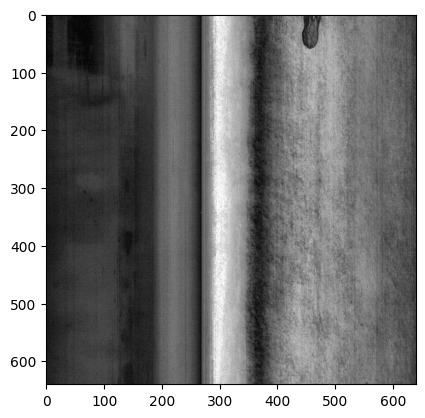

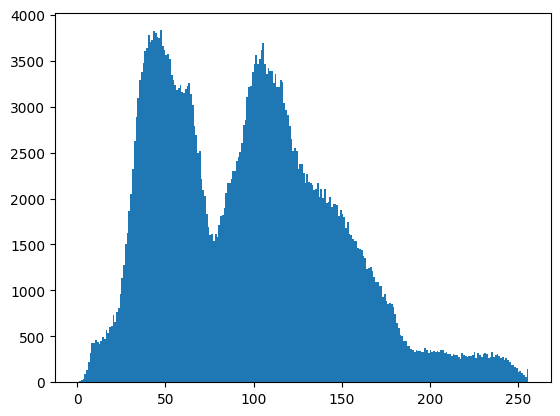

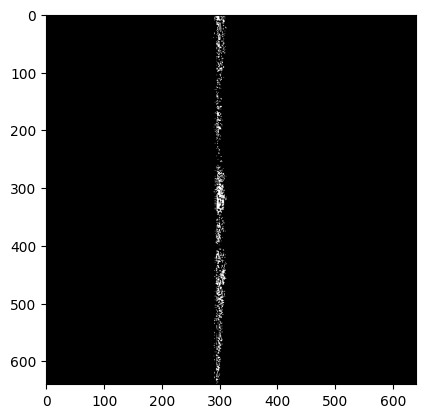

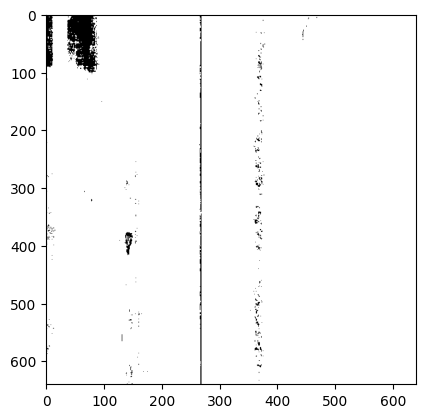

In [67]:
from matplotlib import pyplot as plt

path = '/Data4/student_zhihan_data/data/GC10-DET/test/images/img_01_425000300_00630_jpg.rf.12001adc8b86faf88a47b6aa6f321b91.jpg'
img = cv2.imread(path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()

# plot the distribution of brightness
plt.hist(gray.ravel(), 256, [0, 256])
plt.show()


# annotate pixels with value > 200
plt.imshow(gray > 240, cmap='gray')
plt.show()

plt.imshow(gray > 20, cmap='gray')
plt.show()

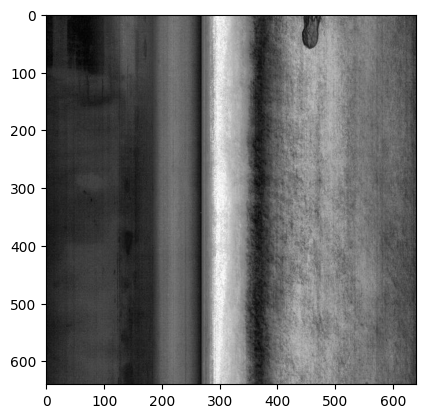

In [26]:
plt.imshow(adjust_brightness(img, value=0), cmap='gray')
plt.show()

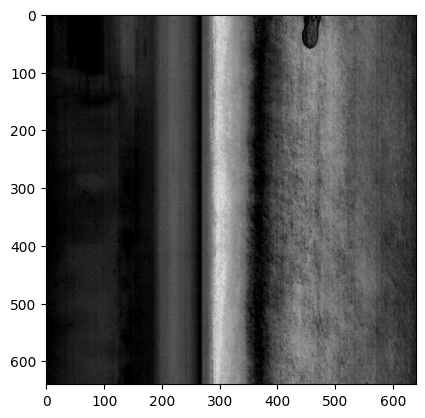

In [27]:
plt.imshow(adjust_brightness(img, value=-30), cmap='gray')
plt.show()

In [10]:
import sys
import os
def create_dataset_with_adjust_brightness(brightness=0, base="NEU-DET"):
    # mkdir
    name = f"{base}_brightness_{brightness}"
    path = os.path.join('/Data4/student_zhihan_data/data', name)
    if not os.path.exists(path):
        os.mkdir(path)
        # create train, val, test directory
        os.mkdir(os.path.join(path, 'train'))
        os.mkdir(os.path.join(path, 'valid'))
        os.mkdir(os.path.join(path, 'test'))
        # copy images
        os.system(f"cp -r /Data4/student_zhihan_data/data/{base}/train/* {path}/train")
        os.system(f"cp -r /Data4/student_zhihan_data/data/{base}/valid/* {path}/valid")
        os.system(f"cp -r /Data4/student_zhihan_data/data/{base}/test/* {path}/test")
        # copy configure file
        os.system(f"cp /Data4/student_zhihan_data/data/{base}/data.yaml {path}")

    # adjust brightness of images in train, val, test directory
    for dir in ['train', 'valid', 'test']:
        for img in os.listdir(os.path.join(path, dir, "images")):
            img_path = os.path.join(path, dir, "images", img)
            img = cv2.imread(img_path)
            img = adjust_brightness(img, value=brightness)
            cv2.imwrite(img_path, img)

In [13]:
for i in [50,70,10,20,110]:
    create_dataset_with_adjust_brightness(brightness=i, base="GC10-DET")

In [13]:
from scipy import stats
import numpy as np
def cal_SRCC(x:np.array, y:np.array):
    """calculate SRCC
    Args:
        x (_type_): x
        y (_type_): y
    """
    res = stats.spearmanr(x, y)
    
    return res

cal_SRCC(np.array([5,3,1,2,4,6]),np.array([5,3,2,1,4,6]))

SignificanceResult(statistic=0.942857142857143, pvalue=0.004804664723032055)

In [9]:
def cal_SRCC_with_tied_rankings(x:np.array, y=np.array):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = len(x)
    sum_ = 0
    for i in range(n):
        sum_ += (x[i] - x_mean) * (y[i] - y_mean)
    scale = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    r = sum_ / scale
    
    return r

In [11]:
cal_SRCC_with_tied_rankings(np.array([5,3,1,2,4,6]),np.array([5,3,2,1,4,6]))

0.9428571428571428

In [19]:
YOLO = [5,3,1,2,4,6]
Proposed = [5,3,2,1,4,6]
SSD = [5,4,2,1,3,6]
FCNN = [5,4,2,1,3,6]

print(cal_SRCC_with_tied_rankings(YOLO, Proposed))
print(cal_SRCC_with_tied_rankings(Proposed, SSD))
print(cal_SRCC_with_tied_rankings(Proposed, FCNN))

0.9428571428571428
0.9428571428571428
0.9428571428571428
PearsonRResult(statistic=0.9428571428571427, pvalue=0.00480466472303211)
PearsonRResult(statistic=0.9428571428571427, pvalue=0.00480466472303211)
PearsonRResult(statistic=0.9428571428571427, pvalue=0.00480466472303211)


In [20]:

proposed_value = [67.6, 68.5, 69.5, 70.3, 67.6, 37.0]
yolo_value = [64.9, 76, 80, 79.3, 75.4, 47.3]
stats.pearsonr(proposed_value, yolo_value)

PearsonRResult(statistic=0.9257676049029817, pvalue=0.008061145828326888)